![image](dependencies/open-science-prize.png)

## Higher Fidelity Graph States
In this notebook, we will prepare quantum circuits for a 7-qubit graph state and estimate the fidelity through stabilizer measurements using Qiskit. In this example, we use the CTMP method of error mitigation [1] and repeat the graph state measurement 16 times to find statistical error bars.

**To Do:
Modify the graph state preparation circuit or use your own methods of error mitigation to improve the graph state fidelity.**


[1] S. Bravyi, S. Sheldon, A. Kandala, D.C. McKay, J.M. Gambetta, Mitigating measurement errors in multi-qubit experiments, [arXiv:2006.14044](https://arxiv.org/abs/2006.14044) (2020).

## Imports

Begin by importing the necessary packages and defining the functions we will need for the stabilizer measurements.

In [1]:
### install Qiskit and other modules if you don't have them already
!pip install -r dependencies/requirements.txt --quiet

In [2]:
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In order to run the circuits, first load the backend `ibmq_casablanca` from your account using the `IBMQ` provider. You will receive access to `ibm-q-community/ibmquantumawards/open-science` after registering for the Open Science Prize.

In [3]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Preparing graph states

Here, we prepare the graph state circuit for 7-qubits using the `GraphState` function in Qiskit's circuit library. We define a graph that uses the connectivity map of the quantum system `ibmq_casablanca`.

In [4]:
num_qubits = 7

# adjacency matrix for `ibmq_casablanca`
adjmat = [
    [0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 0, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 0, 0, 0, 1, 0]]

### Your code goes here

How would you prepare a graph state with high fidelity? In the example below, we create it using Qiskit's circuit library at the gate level. You may explore other methods for creating the graph states, including by using pulse-level techniques or accounting for the errors in the quantum system.

In [5]:
def create_graph_state():
    
    ### YOUR CODE GOES HERE -- START
    
    graph_state_circuit = circuit_library.GraphState(adjmat)
    
    ### YOUR CODE GOES HERE -- END
    
    return graph_state_circuit

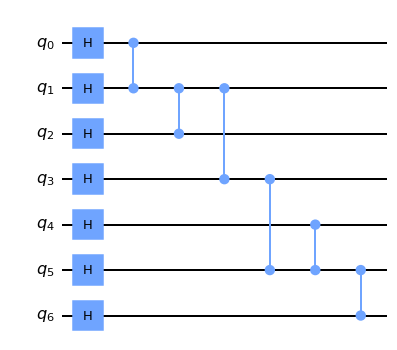

In [6]:
# the graph state can be created using Qiskit's circuit library
state_circuit = create_graph_state()
state_circuit.draw()

## Creating and measuring stabilizers

We begin by defining functions to create stabilizer measurement circuits, and then appending them onto the circuit used to create the graph states.

In [7]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.
    
    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.
    
    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

In [8]:
## Compute the stabilizers for this graph state
generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
print('Generators:', generators)

Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

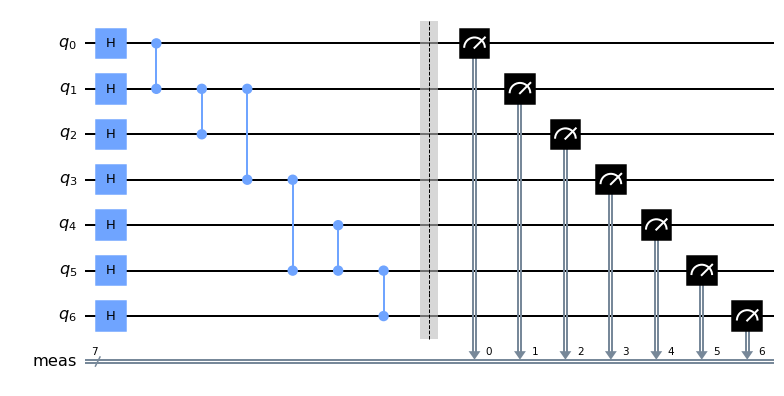

In [9]:
## Append the stabilizer measurements to the graph state circuit 
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

stabilizer_circuits[0].draw()

## Measurement mitigation

Noisy measurements impact our ability to accurately measure the state fidelity. For our default example we calibrate our measurements for the CTMP method using states with two-qubit excitations.

In [10]:
labels = ['0000000', '0000011', '0000101', 
          '0001001', '0001010', '0001100', 
          '0010001', '0010010', '0010100', '0011000', 
          '0100001', '0100010', '0100100', '0101000', '0110000', 
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000', 
          '1111111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)

In [11]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))

## Run the circuits

We will run the circuits on the `ibmq_casablanca` quantum system.

In order to debug more quickly and avoid queues, you may consider using a simulator backend modeled after the real quantum system. This will use the noise model of `ibmq_casablanca` to do simulations. You may uncomment the line below to do so. **Note that the fidelities of your graph states will generally be higher on the simulator, but the Open Science Prize is awarded for the best fidelities on the real quantum system.**

In [12]:
# backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))

We run the measurement calibration circuits in a separate job from the graph state circuits.  We repeat both 16 times and use the mean as the final value. 

In order to debug more quickly, you may consider reducing `reps` from 16 to 1. **Note that the final submissions will need to be executed with 16 repetitions.**

In [13]:
reps = 16

In [14]:
all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]
    
    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)

Job IDs (1/16): 
 measurement calibration: 5fc6ae9d667e1d0019e27c8d
 stabilizer measurements: 5fc6ae92409629001ab814fe
Job IDs (2/16): 
 measurement calibration: 5fc6aeb227482400199aa9fe
 stabilizer measurements: 5fc6aea77a8d9a0019d4c156
Job IDs (3/16): 
 measurement calibration: 5fc6aec7cb8ccc001a95c3ef
 stabilizer measurements: 5fc6aebd24c9e90019f924cb
Job IDs (4/16): 
 measurement calibration: 5fc6aedd46ea68001af54f10
 stabilizer measurements: 5fc6aed2409629001ab81501
Job IDs (5/16): 
 measurement calibration: 5fc6aef6cb8ccc001a95c3f2
 stabilizer measurements: 5fc6aeea409629001ab81503
Job IDs (6/16): 
 measurement calibration: 5fc6af0e667e1d0019e27c93
 stabilizer measurements: 5fc6af0327482400199aaa01
Job IDs (7/16): 
 measurement calibration: 5fc6af2924c9e90019f924d2
 stabilizer measurements: 5fc6af1b7a8d9a0019d4c15c
Job IDs (8/16): 
 measurement calibration: 5fc6af3ecb8ccc001a95c3f7
 stabilizer measurements: 5fc6af34667e1d0019e27c94
Job IDs (9/16): 
 measurement calibration: 5fc6a

We can monitor the status of the jobs using Qiskit's job monitoring tools.

In [15]:
for job in all_jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


## Post-processing and computing fidelities

Once the jobs are completed, we can get the results back as follows.

In [16]:
result_backend = []
result_mit_backend = []
for job in all_jobs:
    # Retrieve results (this may take a while depending on the queue)
    result_backend.append(job.result())
    
for job in all_jobs_mit:
    result_mit_backend.append(job.result())

Finally, we compute the fidelities of the graph states. You may consider creating your own method for error mitigation by updating the `stabilizer_expvals` function below. Here, we will use the default methods provided in Qiskit.

In [17]:
def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag
    
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

### Your code goes here

You may consider updating the function below to change how the measurement calibration circuits are used to compute the fidelity of the graph state.

In [18]:
def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""

    ### YOUR CODE GOES HERE -- START
    
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

    ### YOUR CODE GOES HERE -- END

In [19]:
## Mitigate the stabilizer expectation values 
F_nomit_backend = []
F_mit_backend = []

for ii in range(reps):
    # Unmitigated Expectation Values
    expvals_nomit_b, stddevs_nomit_b = stabilizer_expvals(
        result_backend[ii], stabilizers)
  
    # Fit measurement error mitigators
    mitigator_backend = mit.ExpvalMeasMitigatorFitter(result_mit_backend[ii], metadata).fit()

    # Measurement error mitigated expectation values
    expvals_mit_b, stddevs_mit_b = stabilizer_expvals(
        result_backend[ii], stabilizers, meas_mitigator=mitigator_backend)
    
    # save the fidelities for this iteration
    F_nomit_backend.append(stabilizer_fidelity(expvals_nomit_b, stddevs_nomit_b)[0])
    F_mit_backend.append(stabilizer_fidelity(expvals_mit_b, stddevs_mit_b)[0])

Report the fidelity estimates.

In [20]:
## The final results

print('Graph-state fidelity estimates')
print('\nNo mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_nomit_backend), np.std(F_nomit_backend)))

print('\nCTMP error mitigation')
print('F({}) = {:.3f} \u00B1 {:.3f}'.format(
    properties.backend_name, np.mean(F_mit_backend), np.std(F_mit_backend)))

Graph-state fidelity estimates

No mitigation
F(ibmq_casablanca) = 0.647 ± 0.016

CTMP error mitigation
F(ibmq_casablanca) = 0.782 ± 0.018


## Qiskit version

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table